## Tarea de visión por computadora y métricas de evaluación

La tarea a resolver es un problema de **clasificación multiclase** de imágenes con una sola etiqueta por muestra.  
Cada imagen del dataset TrashNet

 Instalar esta version de pytorch para XPU Intel
 
 pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/xpu

In [ ]:
import torch
import sys

def get_device():
    # Prioridad 1: GPU 
    if torch.cuda.is_available():
        print(f"Hardware: NVIDIA GPU ({torch.cuda.get_device_name(0)})")
        return torch.device("cuda")
    
    # Prioridad 2: GPU Intel (XPU)
    
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        print(f"Hardware: Intel GPU ({torch.xpu.get_device_name(0)})")
        return torch.device("xpu")
    
    # Fallback: CPU
    print("Hardware: CPU")
    return torch.device("cpu")

try:
    DEVICE = get_device()  
    print(f"PyTorch version: {torch.__version__}")
    
    # Prueba rápida de memoria
    if DEVICE.type == 'xpu':  
        x = torch.ones(1, device=DEVICE) 
        print("Estado: Tensor en GPU creado correctamente")

except Exception as e:
    print(f"Error al inicializar dispositivo: {e}")
    DEVICE = torch.device("cpu")

print("Dispositivo en uso:", DEVICE)

Hardware: Intel GPU (Intel(R) Arc(TM) Graphics)
PyTorch version: 2.10.0.dev20251124+xpu
Estado: Tensor en GPU creado correctamente
Dispositivo en uso: xpu


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

import shutil
import os

# Ensure only the 'dataset-resized' folder is placed in the project root
root_dir = os.getcwd()
src_dataset_dir = os.path.join(path, "dataset-resized")
alt_src_dataset_dir = os.path.join(root_dir, "1", "dataset-resized")
dest_dataset_dir = os.path.join(root_dir, "dataset-resized")

# Prefer moving from an existing '1/dataset-resized' if present to avoid duplicates
if os.path.exists(alt_src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    shutil.move(alt_src_dataset_dir, dest_dataset_dir)
    # Remove empty '1' dir if it's now empty
    try:
        os.rmdir(os.path.join(root_dir, "1"))
    except OSError:
        pass
    print("Dataset moved from '1' to:", dest_dataset_dir)
elif os.path.exists(src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    # Copy the dataset instead of moving it due to read-only filesystem
    shutil.copytree(src_dataset_dir, dest_dataset_dir)
    print("Dataset copied to:", dest_dataset_dir)
else:
    raise FileNotFoundError("No 'dataset-resized' folder found in download path.")

Path to dataset files: C:\Users\erlin_fokc1mg\.cache\kagglehub\datasets\feyzazkefe\trashnet\versions\1
Dataset copied to: c:\Users\erlin_fokc1mg\OneDrive\Cursos\UBA-AI\BIM4\VCII\dataset-resized


## Análisis Exploratorio de Datos
  1) Análisis de distribución de colores
  2) Análisis de bounding boxes
  3) Analisis de distribución de etiquetas
  4) Dimensión de imagenes y relación de aspectos
  5) Calidad de imágenes

### Visializacion del Dataset

Clases encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


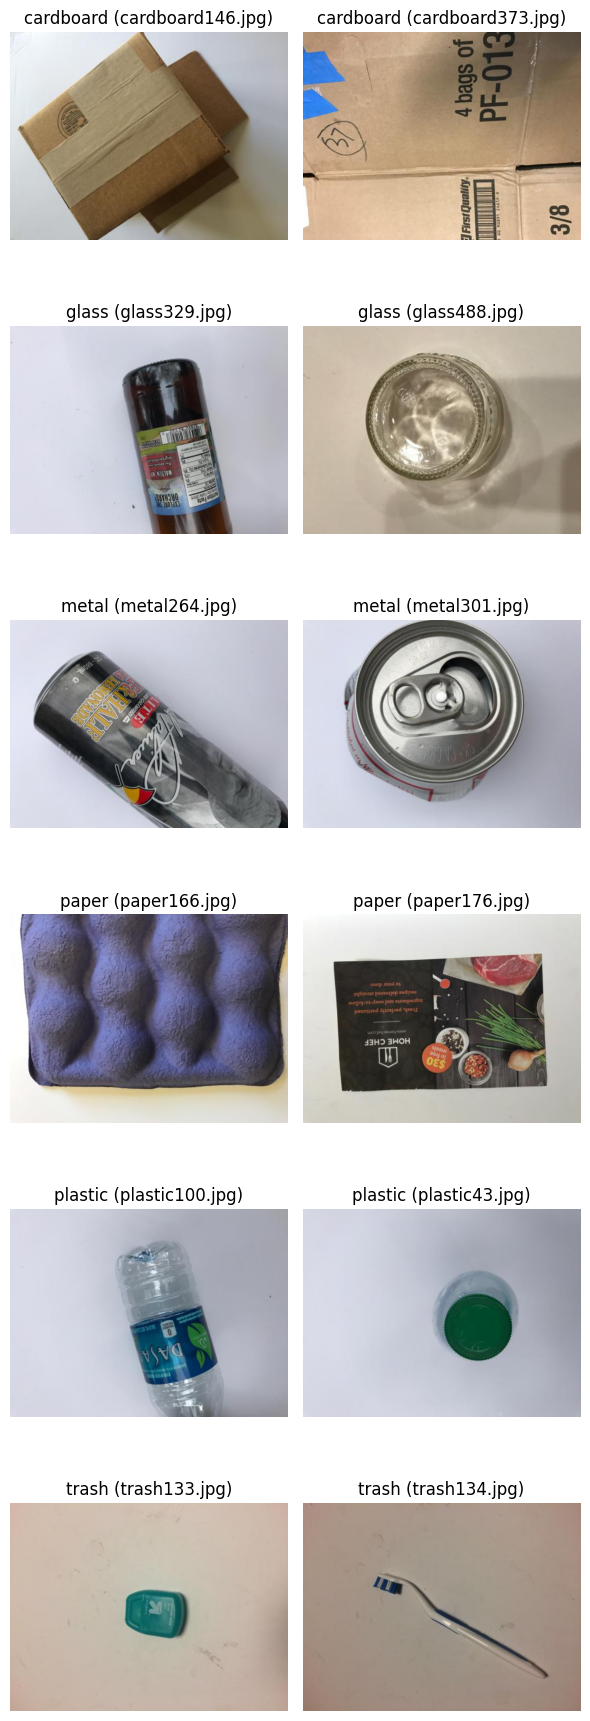

In [3]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Ruta del dataset
dataset_dir = "dataset-resized"

# Obtener las clases (subcarpetas)
classes = sorted(os.listdir(dataset_dir))
print("Clases encontradas:", classes)

# Crear una figura
fig, axes = plt.subplots(len(classes), 2, figsize=(6, 3 * len(classes)))

for i, cls in enumerate(classes):
    class_dir = os.path.join(dataset_dir, cls)
    images = os.listdir(class_dir)

    # Seleccionar 2 imágenes al azar
    sample_images = random.sample(images, 2)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{cls} ({img_name})")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


### Análisis visual por clase

Se revisaron ejemplos representativos de cada categoría del dataset TrashNet. A partir de esta inspección inicial se observan los siguientes patrones:

- **Composición y foco:**  
  El objeto principal suele estar claramente visible y ocupa una porción relevante de la imagen. No se detectaron imágenes corruptas o completamente fuera de foco, aunque en algunos casos el encuadre es algo irregular.

- **Iluminación y fondo:**  
  Hay variaciones apreciables en iluminación y color de fondo (blancos, beige, rosados). Estas diferencias pueden hacer que el modelo aprenda a apoyarse en el fondo o la tonalidad global en lugar de centrarse únicamente en el objeto.

- **Similitud entre *cardboard* y *paper*:**  
  Ambas clases muestran texturas y tonalidades bastante parecidas, lo que sugiere que el modelo podría confundirlas con facilidad si no se dispone de señales visuales más finas.

- **Reflejos en *plastic* y *glass*:**  
  En estas clases aparecen frecuentemente brillos y transparencias, que introducen mayor variabilidad en la apariencia de los objetos y pueden dificultar la separación clara entre categorías.

- **Heterogeneidad en *trash*:**  
  La clase *trash* incluye objetos compuestos por múltiples materiales (envoltorios, envases mixtos, etc.), lo que la convierte en una categoría visualmente más ambigua.

- **Sombras y variaciones leves:**  
  Algunas imágenes presentan sombras marcadas o diferencias de centrado, lo que introduce cierto nivel de ruido, aunque sigue siendo manejable.

En conjunto, el dataset resulta adecuado para la tarea de clasificación de residuos, pero la variabilidad en iluminación, fondos y similitud entre ciertas clases indica que será importante considerar técnicas de robustez (p. ej., data augmentation y normalización) en las etapas de modelado.



### Mapa de calor

================= Identificación de las clases del dataset =================
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
================= Análisis de tipos y tamaños de imagen =================
Formatos de imagen encontrados:
  .jpg: 2527 imágenes

Tamaños de imagen encontrados (ancho × alto):
  512×384: 2527 imágenes

Cantidad total de imágenes analizadas: 2527
Cantidad de tamaños distintos: 1

================= Distribución de colores por clase =================



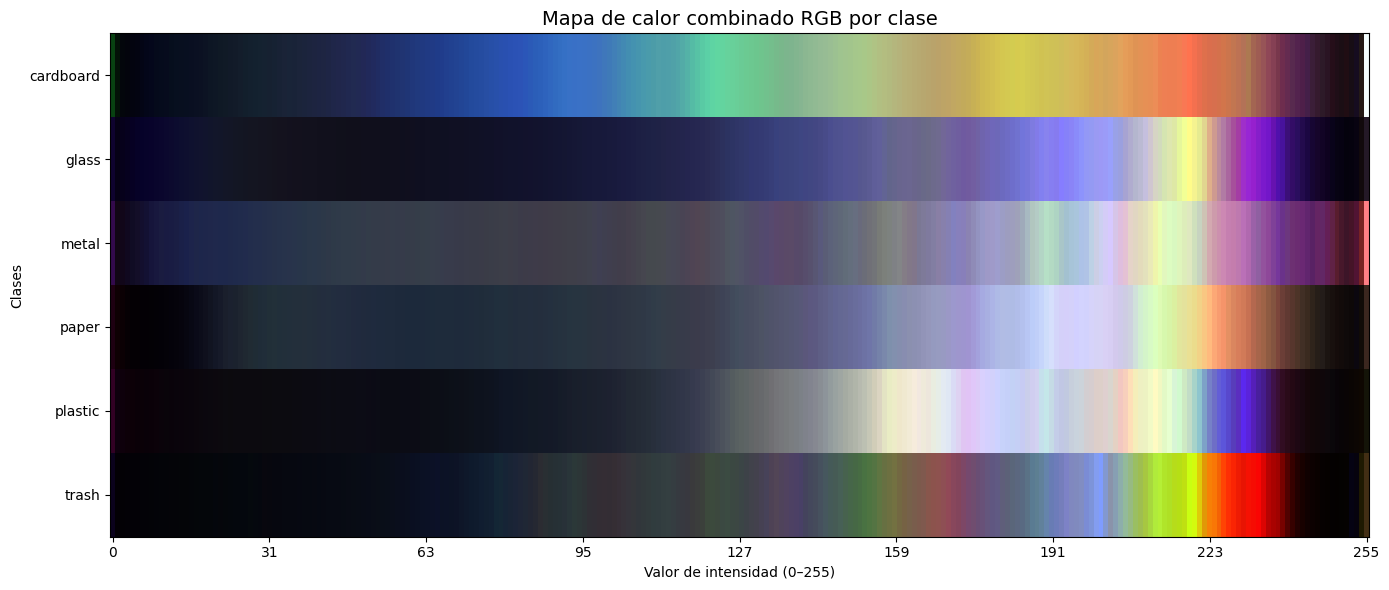

In [4]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ===== CONFIGURACIÓN =====
root_dir = ""
dataset_path = os.path.join(root_dir, "dataset-resized")
image_exts = (".jpg", ".png", ".jpeg")

# ===== CHEQUEO DEL DATASET =====
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" No se encontró el dataset en: {dataset_path}")

classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])
print("================= Identificación de las clases del dataset =================")
print("Classes:", classes)

# ===== CÁLCULO DE DISTRIBUCIÓN RGB =====
color_distributions = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    if len(images) == 0:
        print(f"Clase '{cls}' sin imágenes válidas")
        continue

    hist_sum = np.zeros((256, 3))
    count = 0

    for filename in images:
        image_path = os.path.join(class_path, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error al leer {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_sum[:, i] += hist.flatten()
        count += 1

    if count > 0:
        hist_avg = hist_sum / count
        # Normalizamos cada canal entre 0 y 1
        hist_norm = hist_avg / hist_avg.max(axis=0)
        color_distributions[cls] = hist_norm
# Inicializamos contadores
format_counter = Counter()
size_counter = Counter()

print("================= Análisis de tipos y tamaños de imagen =================")

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    for filename in images:
        image_path = os.path.join(class_path, filename)
        ext = os.path.splitext(filename)[-1].lower()
        format_counter[ext] += 1

        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            size_counter[(w, h)] += 1
        else:
            print(f" No se pudo leer: {image_path}")

# Mostrar conteo de formatos
print("Formatos de imagen encontrados:")
for ext, count in format_counter.items():
    print(f"  {ext}: {count} imágenes")


# Mostrar tamaños únicos
print("\nTamaños de imagen encontrados (ancho × alto):")
for (w, h), count in size_counter.most_common():
    print(f"  {w}×{h}: {count} imágenes")

print("\nCantidad total de imágenes analizadas:", sum(format_counter.values()))
print("Cantidad de tamaños distintos:", len(size_counter))


# ===== COMBINACIÓN RGB EN UN SOLO MAPA =====
# Creamos una "imagen" donde cada fila es una clase y las columnas representan valores de 0–255
height = len(color_distributions)
width = 256
combined_img = np.zeros((height, width, 3))

for idx, cls in enumerate(color_distributions):
    combined_img[idx, :, :] = color_distributions[cls]

# ===== VISUALIZACIÓN =====
print("\n================= Distribución de colores por clase =================\n")
plt.figure(figsize=(14, 6))
plt.imshow(combined_img, aspect='auto')
plt.yticks(range(len(color_distributions)), list(color_distributions.keys()))
plt.xticks(np.linspace(0, 255, 9), [f"{int(v)}" for v in np.linspace(0, 255, 9)])
plt.title("Mapa de calor combinado RGB por clase", fontsize=14)
plt.xlabel("Valor de intensidad (0–255)")
plt.ylabel("Clases")
plt.tight_layout()
plt.show()





- **Clases detectadas:**  
  El dataset está organizado en seis categorías bien definidas: `cardboard`, `glass`, `metal`, `paper`, `plastic` y `trash`. La estructura es clara y consistente, sin subcarpetas inesperadas ni clases residuales. Esto simplifica bastante el pipeline de carga y evita preprocesamiento extra.

- **Formato y resolución uniforme:**  
  Todas las imágenes están en formato `.jpg` y comparten exactamente la misma resolución: **512×384**.  
  Esto es una ventaja importante porque elimina la necesidad de manejar variaciones de tamaño en la etapa de preprocesamiento y garantiza que no hay ruido estructural introducido por diferentes fuentes o cámaras.

- **Homogeneidad en dimensiones:**  
  El hecho de que exista **un único tamaño** para las 2527 imágenes confirma que el dataset fue estandarizado previamente. Técnicamente, esto reduce la variabilidad no deseada, pero también implica que el modelo no verá variaciones reales de escala. Esto refuerza aún más la necesidad de **data augmentation** orientado a robustez (crops, escalas, rotaciones).

- **Distribución de color perceptual por clase:**  

El mapa de calor RGB muestra que cada clase sigue patrones cromáticos distintos, aunque no siempre bien separables:

- **cardboard y paper** comparten gamas oscuras y tonos suaves, lo que anticipa solapamiento visual.  
- **glass y plastic** presentan mayor variabilidad por reflejos y transparencias.  
- **metal** tiende a distribuciones más frías y relativamente uniformes.  
- **trash** es la categoría más dispersa, coherente con su heterogeneidad de materiales.

En conjunto, el dataset es consistente y está bien estructurado, pero muestra **variabilidad cromática y similitudes entre clases**, especialmente en pares como *cardboard–paper* y *glass–plastic*.  
Esto sugiere que los modelos más simples pueden confundirse entre categorías visualmente próximas, y refuerza la conveniencia de aplicar **data augmentation** y, en etapas posteriores, evaluar un **modelo preentrenado** que pueda manejar mejor estas variaciones.


Total de imágenes: 2527
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


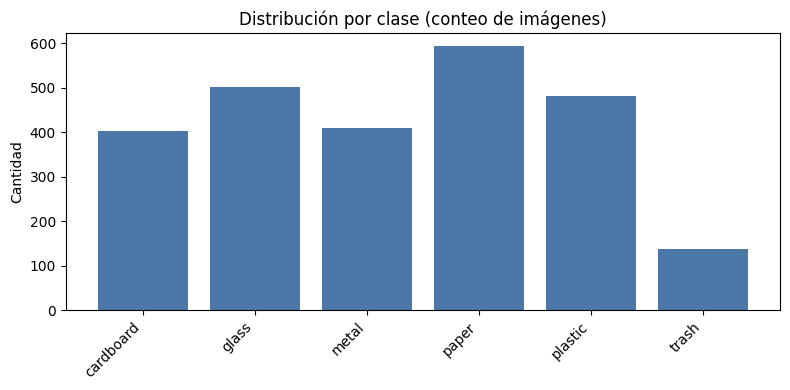

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Ubicación del dataset
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):
    raise FileNotFoundError(f"No se encontró 'dataset-resized' en: {dataset_dir}")

image_exts = (".jpg",)
class_to_count = {}

# Contar imágenes por clase (una subcarpeta por clase)
for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    num_images = sum(
        1 for f in os.listdir(class_path)
        if f.lower().endswith(image_exts)
    )
    class_to_count[class_name] = num_images

# Mostrar conteos
total_images = sum(class_to_count.values())
print("Total de imágenes:", total_images)
for cls, cnt in class_to_count.items():
    print(f"{cls}: {cnt}")

# Gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(list(class_to_count.keys()), list(class_to_count.values()), color="#4C78A8")
plt.title("Distribución por clase (conteo de imágenes)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


###  Distribución de clases

El dataset **TrashNet** contiene un total de **2527 imágenes**, distribuidas en seis categorías:

| Clase     | Cantidad | Proporción (%) |
|------------|-----------|----------------|
| cardboard  | 403 | 15.9 |
| glass      | 501 | 19.8 |
| metal      | 410 | 16.2 |
| paper      | 594 | 23.5 |
| plastic    | 482 | 19.1 |
| trash      | 137 | 5.4 |

Se observa una **ligera desbalance entre clases**, especialmente con la categoría **trash**, que representa solo alrededor del 5 % del total de muestras.  
Esto puede afectar el entrenamiento del modelo, generando un sesgo hacia las clases mayoritarias (*paper*, *glass*, *plastic*).  

> **Conclusión:**  
> El dataset presenta un **moderado desbalance**, pero sigue siendo adecuado para entrenamiento supervisado.  
> Se recomienda aplicar estrategias de **data augmentation** o **ponderación de clases** para compensar la baja representación de la clase *trash* en las etapas posteriores.


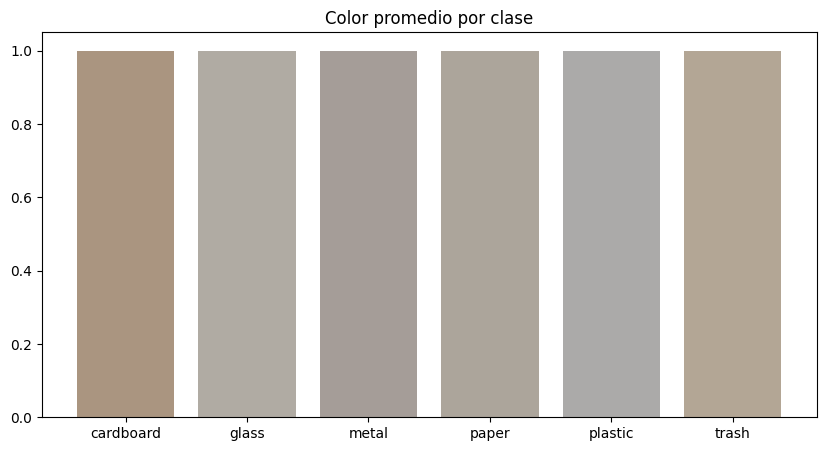

 No se encontraron archivos .txt de anotaciones (bounding boxes).


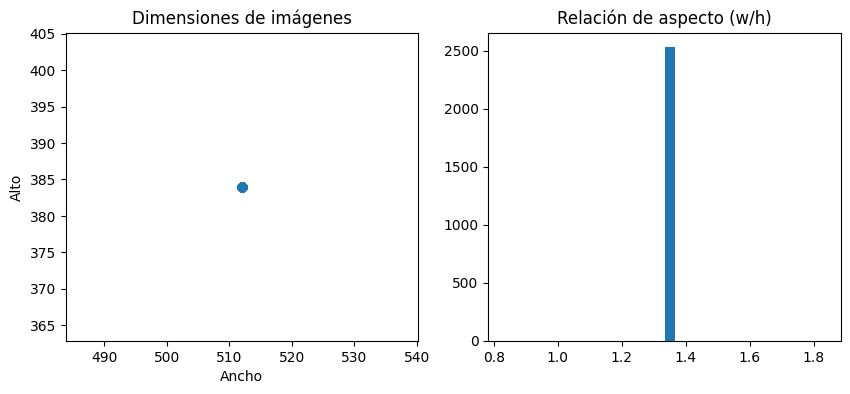

Tamaños únicos: 1


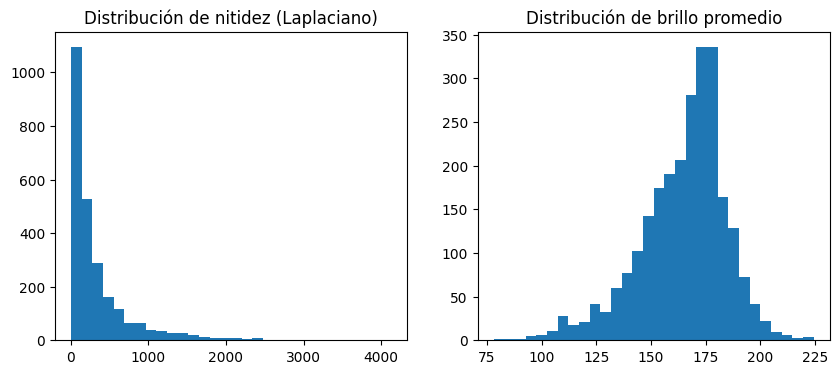

Imágenes analizadas: 2527
Nitidez promedio: 334.56, Brillo promedio: 164.69


In [6]:
# Análisis Exploratorio del Dataset (EDA)

import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import collections


root_dir = "." # Placeholder
dataset_path = os.path.join(root_dir, "dataset-resized")


classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])



# Distribución de colores por clase promedio
color_means = {}
for cls in classes:
    path = os.path.join(dataset_path, cls)
    imgs = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    col_sum = np.zeros(3); count = 0
    for img_file in imgs:
        img = cv2.imread(os.path.join(path, img_file))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        col_sum += img.mean(axis=(0,1))
        count += 1
    if count>0: color_means[cls] = col_sum/count

plt.figure(figsize=(10,5))
plt.bar(color_means.keys(), [1]*len(color_means), color=list(color_means.values()))
plt.title("Color promedio por clase")
plt.show()


# Bounding Boxes

bbox_sizes, aspect_ratios = [], []
for txt in glob.glob(os.path.join(dataset_path, "**/*.txt"), recursive=True):
    with open(txt) as f:
        for line in f:
            vals = line.strip().split()
            if len(vals) != 5: continue
            _, x, y, w, h = map(float, vals)
            bbox_sizes.append(w*h)
            aspect_ratios.append(w/h)

if bbox_sizes:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(bbox_sizes, bins=30); plt.title("Distribución tamaños Bounding Boxes")
    plt.subplot(1,2,2); plt.hist(aspect_ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
else:
    print(" No se encontraron archivos .txt de anotaciones (bounding boxes).")


# Dimensiones de imágenes y relación de aspecto

sizes, ratios = [], []
for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        h, w = img.shape[:2]
        sizes.append((w, h))
        ratios.append(w/h)

if sizes:
    ws, hs = zip(*sizes)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.scatter(ws, hs, alpha=0.5); plt.xlabel("Ancho"); plt.ylabel("Alto"); plt.title("Dimensiones de imágenes")
    plt.subplot(1,2,2); plt.hist(ratios, bins=30); plt.title("Relación de aspecto (w/h)")
    plt.show()
    print(f"Tamaños únicos: {len(set(sizes))}")
else:
    print("No se pudieron leer imágenes para calcular dimensiones.")


# Calidad de imágenes (brillo y nitidez)

sharpness, brightness = [], []

for cls in classes:
    path = os.path.join(dataset_path, cls)
    for f in os.listdir(path):
        if not f.endswith(('.jpg','.png','.jpeg')): continue
        img = cv2.imread(os.path.join(path, f))
        if img is None: continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sharpness.append(cv2.Laplacian(gray, cv2.CV_64F).var())
        brightness.append(gray.mean())

if sharpness:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(sharpness, bins=30); plt.title("Distribución de nitidez (Laplaciano)")
    plt.subplot(1,2,2); plt.hist(brightness, bins=30); plt.title("Distribución de brillo promedio")
    plt.show()

    print(f"Imágenes analizadas: {len(sharpness)}")
    print(f"Nitidez promedio: {np.mean(sharpness):.2f}, Brillo promedio: {np.mean(brightness):.2f}")
else:
    print(" No se analizaron imágenes para calidad.")

###  Análisis de tamaños y resoluciones

Todas las imágenes del dataset presentan una resolución uniforme de **512 × 384 píxeles**.  
El tamaño promedio, mínimo y máximo coincide exactamente, lo que indica que **no existen variaciones de resolución** entre las muestras.

| Métrica | Ancho (px) | Alto (px) |
|----------|-------------|-----------|
| Promedio | 512.0 | 384.0 |
| Mínimo   | 512 | 384 |
| Máximo   | 512 | 384 |

>  **Conclusión:**  
> El dataset fue previamente **redimensionado y normalizado en tamaño**, lo que facilita su procesamiento y permite utilizar directamente las imágenes en redes convolucionales sin requerir pasos adicionales de rescaling o padding.


### Promedio de color

cardboard: [170.08026354 148.85700061 127.93128957]
glass: [176.37537536 170.51842232 163.09804727]
metal: [164.82827208 157.00576075 151.89657167]
paper: [172.18114987 164.55118311 155.4314591 ]
plastic: [171.08491776 170.0917927  168.97854035]
trash: [178.80407941 166.11302326 149.04588117]


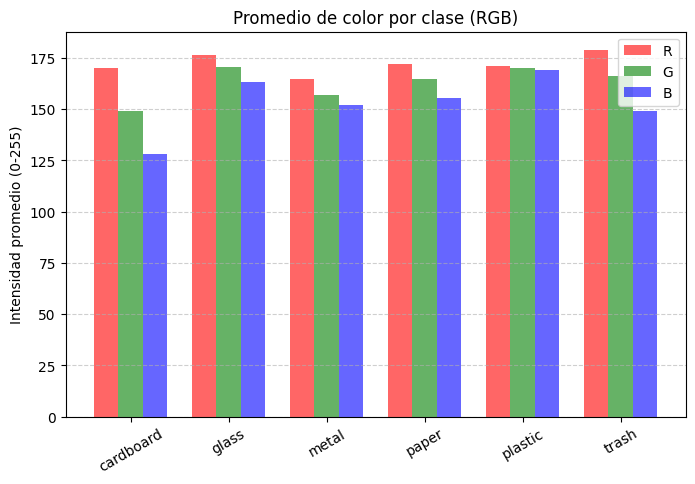

In [7]:
import numpy as np
from PIL import ImageStat

color_means = {}

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    mean_rgb = []
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            stat = ImageStat.Stat(img)
            mean_rgb.append(stat.mean)
    color_means[cls] = np.mean(mean_rgb, axis=0)

for cls, mean in color_means.items():
    print(f"{cls}: {mean}")

import matplotlib.pyplot as plt
import numpy as np

classes = list(color_means.keys())
rgb_values = np.array(list(color_means.values()))

# --- Barplot por canal ---
plt.figure(figsize=(8,5))
x = np.arange(len(classes))
bar_width = 0.25

plt.bar(x - bar_width, rgb_values[:,0], width=bar_width, label='R', color='r', alpha=0.6)
plt.bar(x, rgb_values[:,1], width=bar_width, label='G', color='g', alpha=0.6)
plt.bar(x + bar_width, rgb_values[:,2], width=bar_width, label='B', color='b', alpha=0.6)

plt.xticks(x, classes, rotation=30)
plt.ylabel('Intensidad promedio (0-255)')
plt.title('Promedio de color por clase (RGB)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Análisis de color promedio por clase

El cálculo de la media de intensidades RGB por clase arroja los siguientes valores:

| Clase     | R     | G     | B     |
|-----------|-------|-------|-------|
| cardboard | 170.1 | 148.9 | 127.9 |
| glass     | 176.4 | 170.5 | 163.1 |
| metal     | 164.8 | 157.0 | 151.9 |
| paper     | 172.2 | 164.6 | 155.4 |
| plastic   | 171.1 | 170.1 | 169.0 |
| trash     | 178.8 | 166.1 | 149.0 |

---

### Interpretación

Los promedios RGB muestran una **paleta relativamente homogénea** en todo el dataset, con intensidades altas y tonalidades mayormente neutras. Aun así, se distinguen algunos patrones:

- **cardboard** presenta un componente rojo más alto, coherente con tonos marrones.  
- **glass** y **plastic** tienen valores elevados y bastante balanceados en los tres canales, lo que explica por qué visualmente pueden confundirse (reflejos, superficies claras).  
- **metal** y **paper** exhiben intensidades más moderadas, asociadas a texturas mate y colores grisáceos.  
- **trash** muestra el mayor valor promedio en rojo pero un azul más bajo, lo que apunta a una **mayor variabilidad cromática** dentro de la clase.

En general, las diferencias entre clases existen, pero no son lo suficientemente fuertes como para garantizar separabilidad cromática por sí sola. Esto refuerza la necesidad de que el modelo aprenda **textura, bordes y forma**, y no dependa únicamente del color.


## Tarea de visión por computadora y métricas de evaluación

### Definición de la tarea

El problema a resolver es una **clasificación multiclase** de imágenes con una única etiqueta por muestra.  
Cada imagen del dataset TrashNet debe ser asignada exactamente a una de las 6 categorías:

`cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`.

La distribución de clases es moderadamente desbalanceada: la mayoría de las clases se ubica entre ~16 % y ~24 % de las muestras, mientras que **trash** representa solo ~5 %.  
Por lo tanto, el modelo debe rendir bien **en todas las clases**, no solo en las más frecuentes.

---

### Criterios para elegir la(s) métrica(s)

Al definir las métricas de evaluación, buscamos cumplir tres criterios:

1. **Interpretabilidad global:**  
   Tener una métrica agregada sencilla de entender (¿el modelo acierta mucho o poco en general?).

2. **Sensibilidad al desbalance de clases:**  
   Evitar que una clase minoritaria como *trash* quede “diluida” en un promedio dominado por las clases frecuentes.

3. **Capacidad de comparar modelos:**  
   Usar métricas estables que permitan comparar de forma consistente distintos baselines y configuraciones (desde redes sencillas hasta modelos preentrenados).

---

### Opciones consideradas

- **Accuracy global (proporción de aciertos):**  
  - Ventaja: es intuitiva y permite comparar contra el azar (≈ 16,7 % para 6 clases).  
  - Desventaja: en presencia de desbalance puede ocultar un desempeño pobre en clases minoritarias.  
    Un modelo que prácticamente nunca acierta *trash* podría seguir mostrando una accuracy razonable si se comporta bien en las clases mayoritarias.

- **Precision/Recall por clase:**  
  - Ventaja: permiten analizar con detalle qué tan bien se detecta cada clase y si el modelo tiende a sobre-o sub-predecir alguna etiqueta.  
  - Desventaja: generan varias métricas simultáneas; no ofrecen un único número fácil para comparar modelos.

- **F1-score macro (promedio macro):**  
  - Combina **precision** y **recall** por clase y luego promedia **dando el mismo peso a cada clase**, sin importar cuántas muestras tenga.  
  - Esto hace que errores en una clase minoritaria (por ejemplo, *trash*) impacten tanto como errores en clases frecuentes como *paper* o *glass*.  
  - Es especialmente adecuado cuando el objetivo es que **todas las clases sean importantes** desde el punto de vista de la tarea, aunque el dataset esté desbalanceado.

- **Otras variantes (F1-weighted, balanced accuracy, etc.):**  
  - Son alternativas válidas, pero tienden a ponderar las clases según su frecuencia (F1-weighted) o se solapan en interpretación con F1-macro.  
  - Para este trabajo preferimos usar una métrica principal clara y ampliamente utilizada en clasificación multiclase con desbalance moderado.

---

### Métrica principal y métricas de apoyo

A partir de los criterios anteriores, definimos:

- **Métrica principal de evaluación:**  
  **F1-score macro (F1-macro) en el conjunto de validación.**

  Razones:
  - Trata a todas las clases por igual, incluidas las minoritarias.  
  - Penaliza tanto los falsos positivos como los falsos negativos.  
  - Evita que una buena performance en clases frecuentes o fáciles “tape” un desempeño pobre en *trash* u otras clases confusas (*cardboard vs paper*, *glass vs plastic*).

- **Métricas de apoyo:**  
  Además de F1-macro, reportamos siempre:
  - **Accuracy global de validación** (para una referencia intuitiva del rendimiento agregado).  
  - **Matriz de confusión** y **F1 por clase**, para analizar qué clases se confunden más.

En resumen:

- **Las decisiones entre modelos (cuál es mejor baseline, cuál mejora efectivamente el sistema)** se toman principalmente en función de **F1-macro**.  
- **La accuracy** se utiliza como métrica complementaria de interpretación global y para comparar con el baseline aleatorio.


# Uso de Data Augmentation. 

La decisión de implementar técnicas de **Data Augmentation** en este proyecto constituye una estrategia fundamental para superar las limitaciones inherentes de nuestro dataset y garantizar la capacidad de generalización del modelo. Nuestra justificación para esta elección se articula en cuatro pilares teóricos validados en clase.

---

### 1. Abordaje de la Escasez de Datos

En primer lugar, **debemos abordar** la **escasez de datos** del dataset **TrashNet**, que con aproximadamente 2.500 imágenes resulta insuficiente para entrenar arquitecturas profundas con millones de parámetros sin caer en la memorización.

Mediante la generación de **variaciones sintéticas en tiempo de ejecución**, **buscamos incrementar** el tamaño efectivo del dataset de entrenamiento, exponiendo a la red a una diversidad visual virtualmente infinita sin el costo de recolectar nuevos datos reales.

---

### 2. Mecanismo Principal contra el Overfitting

Simultáneamente, esta estrategia **servirá** como el principal mecanismo para evitar el **sobreentrenamiento (overfitting)**.

Al aplicar **transformaciones geométricas** como **recortes aleatorios (RandomResizedCrop)** y rotaciones, **forzaremos** al modelo a aprender **características estructurales robustas** de los objetos —como la forma de una botella o la textura del cartón— en lugar de memorizar patrones espurios como el fondo o la posición exacta de los píxeles, lo cual **debería evidenciarse** en una mayor estabilidad de nuestras curvas de validación.

---

### 3. Mitigación del Desbalance de Clases

Además, el **Data Augmentation será** clave para mitigar el **desbalance de clases** natural en la distribución de residuos.

Al generar variaciones agresivas de las **clases minoritarias**, **aseguraremos** que el modelo tenga una exposición más equilibrada durante el entrenamiento, evitando que sesgue sus predicciones hacia las clases mayoritarias como el papel o el cartón.

---

### 4. Búsqueda de Robustez y Mejora de Métricas

Finalmente, el uso de **transformaciones fotométricas y espaciales tendrá** un impacto directo en mejorar las métricas finales y la robustez del modelo.

Dado que los residuos en el mundo real no presentan una "pose canónica" ni condiciones de luz controladas, la inyección de ruido mediante **cambios de brillo** y **espejados horizontales dotará** a la red de la **invarianza** necesaria para clasificar correctamente objetos en contextos visuales diversos, superando las limitaciones que tendría un *baseline* inicial.

## Creacion de baseline con un CNN

## Baseline 1: CNN sencilla entrenada desde cero

Como primer baseline se definió una red convolucional pequeña entrenada desde cero sobre TrashNet.  
El objetivo de este modelo no es maximizar la performance, sino establecer un **punto de partida controlado** que permita:

- Verificar rápidamente que el pipeline de datos, las etiquetas y las métricas funcionan correctamente.
- Medir qué puede aprender una arquitectura **poco profunda y de baja capacidad** sin recurrir aún a modelos preentrenados.
- Contar con una referencia clara para evaluar el beneficio real de técnicas posteriores como **transfer learning** y modificaciones de arquitectura.

Las decisiones principales de diseño fueron:

- **Arquitectura simple (SimpleCNN):**  
  Dos bloques `Conv → BatchNorm → ReLU → MaxPool` con 32 y 64 filtros, seguidos de un `Global Average Pooling` y un clasificador totalmente conectado (`Linear → ReLU → Dropout → Linear`).  
  Es una red deliberadamente ligera, entrenable en CPU y con pocas decisiones de diseño (profundidad, filtros, etc.), lo que reduce el riesgo de sobreajustar el baseline.

- **Tamaño de entrada (128×128):**  
  Las imágenes originales (512×384) se redimensionan a 128×128 para abaratar el costo computacional por batch, manteniendo suficiente información espacial para una primera aproximación.

- **Data augmentation moderado:**  
  Se aplican transformaciones geométricas y fotométricas básicas (`RandomResizedCrop`, `HorizontalFlip`, `ColorJitter`, `RandomRotation`) para:
  - compensar la falta de variaciones reales de escala y encuadre en el dataset,  
  - mejorar la robustez del modelo frente a variaciones de iluminación y color observadas en el EDA.

- **Normalización y pesos de clase:**  
  - Se usa la normalización estándar de ImageNet para aprovechar configuraciones típicas de entrenamiento.  
  - Se calculan **class weights** a partir de la distribución de clases, con especial atención a la clase *trash*, que es minoritaria.  
  - La función de pérdida es `CrossEntropyLoss` con `label_smoothing=0.05`, para evitar sobreconfianza en las predicciones.

- **Entrenamiento y regularización:**  
  Se entrena con `AdamW` (lr = 1e-3, `weight_decay` = 1e-4) y se utiliza **early stopping** en función de la pérdida de validación para evitar sobreentrenamiento innecesario.

Este baseline sirve como una **línea de base “desde cero”**: cualquier mejora que se obtenga luego con modelos preentrenados y/o arquitecturas más complejas se interpretará respecto a este punto de partida.
]

In [35]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import os 
import random
from collections import Counter

print("Dispositivo en uso:", DEVICE)

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# Dataset base (desde 'dataset-resized')

root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):

    possible_kaggle_path = "/content/dataset-resized"
    if os.path.isdir(possible_kaggle_path):
        dataset_dir = possible_kaggle_path
    else:
        raise FileNotFoundError(f"No se encontró el dataset en: {dataset_dir}")

# Dataset base sin transforms, solo para metadata
base_ds = datasets.ImageFolder(dataset_dir)
class_names = base_ds.classes
num_classes = len(class_names)
labels = [lbl for _, lbl in base_ds.samples]

print("Clases detectadas:", class_names)
print("num_classes:", num_classes)
print("Cantidad total de imágenes:", len(base_ds))

# ================================================
# Transforms (compatibles con modelos preentrenados)
# ================================================
IMG_SIZE = 224 
VAL_SPLIT = 0.2
BATCH_SIZE = 128 

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# Split estratificado train/val

rng = random.Random(SEED)
label_to_indices = {c: [] for c in range(num_classes)}
for idx, lbl in enumerate(labels):
    label_to_indices[lbl].append(idx)

for c in range(num_classes):
    rng.shuffle(label_to_indices[c])

train_indices, val_indices = [], []
for c, idxs in label_to_indices.items():
    k_val = int(len(idxs) * VAL_SPLIT)
    val_indices.extend(idxs[:k_val])
    train_indices.extend(idxs[k_val:])

print("Tamaño train/val:", len(train_indices), len(val_indices))

# Datasets con transforms
train_ds_full = datasets.ImageFolder(dataset_dir, transform=train_tfms)
val_ds_full = datasets.ImageFolder(dataset_dir, transform=val_tfms)

train_ds = Subset(train_ds_full, train_indices)
val_ds = Subset(val_ds_full, val_indices)


# AUTOMATIZACIÓN DE WORKERS Y MEMORIA


# Detectar cantidad de núcleos lógicos
cpu_count = os.cpu_count()

# Decidir WORKERS según el Sistema Operativo
if os.name == 'nt': 
    WORKERS = min(4, cpu_count)
else: 
    WORKERS = min(8, cpu_count)

print(f"--> Configuración automática: Usando {WORKERS} workers para cargar datos.")

# Decidir pin_memory 

USE_PIN_MEMORY = (DEVICE.type != 'cpu')
print(f"--> Pin Memory: {USE_PIN_MEMORY} (Optimizado para {DEVICE.type})")

# DataLoaders Optimizados
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=USE_PIN_MEMORY,
    persistent_workers=(WORKERS > 0) # Mantiene los procesos vivos para no reiniciarlos en cada época
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=USE_PIN_MEMORY,
    persistent_workers=(WORKERS > 0)
)

# ================================================
# Pesos de clase para CrossEntropy (por desbalance)
# ================================================
class_counts = [0] * num_classes
for idx in train_indices:
    class_counts[labels[idx]] += 1

total_train = sum(class_counts)
class_weights = [total_train / (num_classes * max(1, c)) for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

print("Class weights:", [round(w, 3) for w in class_weights])

Dispositivo en uso: xpu
Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
num_classes: 6
Cantidad total de imágenes: 2527
Tamaño train/val: 2024 503
--> Configuración automática: Usando 4 workers para cargar datos.
--> Pin Memory: True (Optimizado para xpu)
Class weights: [1.044, 0.841, 1.028, 0.709, 0.874, 3.067]


In [37]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_classification_model(model, data_loader, class_names, device):
    """
    Evalúa el modelo, imprime reporte completo y grafica la matriz de confusión 
    normalizada (en porcentajes) para visualizar mejor los errores entre clases.
    """
    model.eval()
    all_targets = []
    all_preds = []

    print(f"Evaluando modelo en {device}...")
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_targets = np.array(all_targets)
    all_preds = np.array(all_preds)

    # 1. Métricas Numéricas
    acc = (all_targets == all_preds).mean()
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    
    print(f"\n{'='*40}")
    print(f"MÉTRICAS GLOBALES")
    print(f"{'='*40}")
    print(f"Accuracy Global: {acc:.4f}")
    print(f"F1-Score Macro:  {f1_macro:.4f}")
    
    print(f"\n{'='*40}")
    print("REPORTE POR CLASE")
    print(f"{'='*40}")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # 2. Graficar Matriz de Confusión (Normalizada)
    cm = confusion_matrix(all_targets, all_preds)
    
    # Normalizamos por filas (True Labels) para ver qué % de cada clase real fue predicho como qué
    # Sumamos un epsilon pequeño por si alguna clase no tuviera muestras (evitar división por cero)
    cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

    plt.figure(figsize=(10, 8))
    # fmt='.1%' formatea el número como porcentaje con 1 decimal (ej. 95.5%)
    sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicción')
    plt.ylabel('Realidad (Ground Truth)')
    plt.title(f'Matriz de Confusión Normalizada (Acc: {acc:.2%})')
    plt.show()

    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "confusion_matrix": cm,
        "confusion_matrix_percent": cm_percent
    }


=== Baseline 1: Iniciando entrenamiento en xpu ===
Epoch 01/50 | Train Loss: 1.7131 Acc: 0.2900 | Val Loss: 1.7201 Acc: 0.3519
Epoch 02/50 | Train Loss: 1.5841 Acc: 0.3794 | Val Loss: 1.6167 Acc: 0.3658
Epoch 03/50 | Train Loss: 1.4987 Acc: 0.4190 | Val Loss: 1.5398 Acc: 0.4135
Epoch 04/50 | Train Loss: 1.4488 Acc: 0.4274 | Val Loss: 1.4927 Acc: 0.4076
Epoch 05/50 | Train Loss: 1.4271 Acc: 0.4481 | Val Loss: 1.4738 Acc: 0.4294
Epoch 06/50 | Train Loss: 1.4086 Acc: 0.4575 | Val Loss: 1.4088 Acc: 0.4672
Epoch 07/50 | Train Loss: 1.3750 Acc: 0.4560 | Val Loss: 1.4374 Acc: 0.4592
Epoch 08/50 | Train Loss: 1.3607 Acc: 0.4867 | Val Loss: 1.4079 Acc: 0.4712
Epoch 09/50 | Train Loss: 1.3414 Acc: 0.4931 | Val Loss: 1.3740 Acc: 0.4732
Epoch 10/50 | Train Loss: 1.3037 Acc: 0.5040 | Val Loss: 1.3822 Acc: 0.4911
Epoch 11/50 | Train Loss: 1.3085 Acc: 0.5143 | Val Loss: 1.3605 Acc: 0.4891
Epoch 12/50 | Train Loss: 1.2960 Acc: 0.5208 | Val Loss: 1.3706 Acc: 0.4990
Epoch 13/50 | Train Loss: 1.3009 Acc

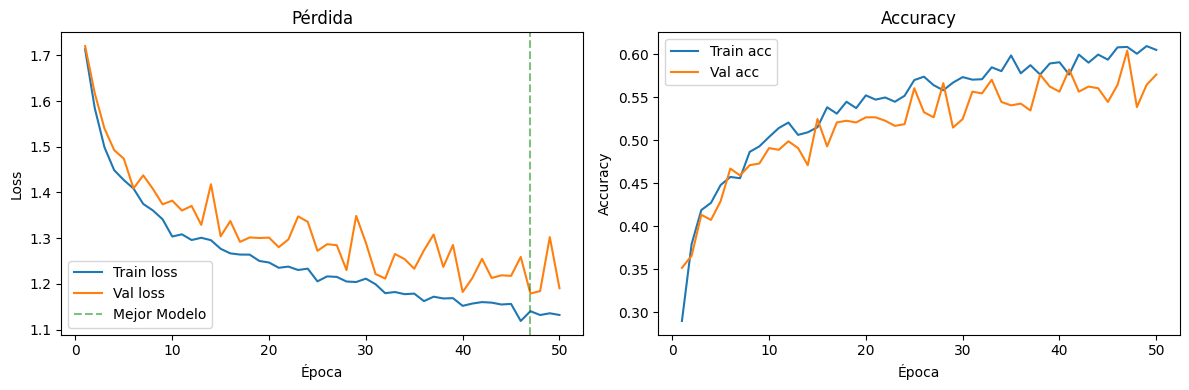


=== Baseline 1: Evaluación Final ===
Evaluando modelo en xpu...

MÉTRICAS GLOBALES
Accuracy Global: 0.6044
F1-Score Macro:  0.5874

REPORTE POR CLASE
              precision    recall  f1-score   support

   cardboard       0.83      0.80      0.82        80
       glass       0.51      0.58      0.54       100
       metal       0.66      0.38      0.48        82
       paper       0.78      0.58      0.67       118
     plastic       0.63      0.65      0.64        96
       trash       0.25      0.74      0.38        27

    accuracy                           0.60       503
   macro avg       0.61      0.62      0.59       503
weighted avg       0.66      0.60      0.62       503



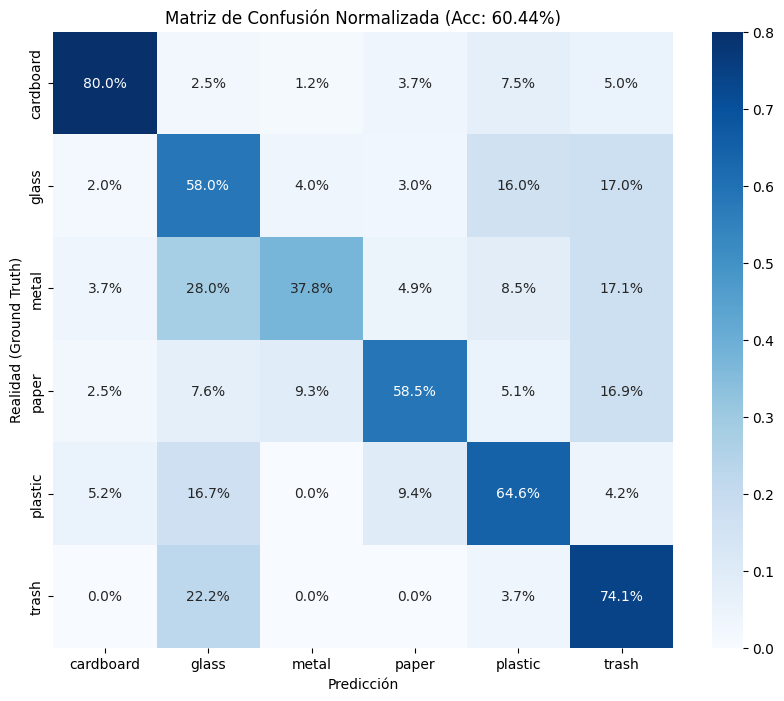

In [38]:
# BASELINE: SIMPLE CNN (ENTRENAMIENTO DINÁMICO)

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import random

# Configuración de semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Definición del modelo Baseline
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# Instanciar modelo, loss y optimizador
model = SimpleCNN(num_classes).to(DEVICE)

# Usamos los pesos de clase ya calculados para manejar el desbalance
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Hiperparámetros de Early Stopping
MAX_EPOCHS = 50   
PATIENCE = 8      

best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

# Listas para logging
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"\n=== Baseline 1: Iniciando entrenamiento en {DEVICE} ===")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS + 1):
    # Fase de entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        # Clipping para estabilidad numérica
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)

    epoch_train_loss = running_loss / max(1, total)
    epoch_train_acc = correct / max(1, total)

    # Fase de validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(DEVICE, non_blocking=True), targets.to(DEVICE, non_blocking=True)
            logits = model(images)
            loss = criterion(logits, targets)

            val_running_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == targets).sum().item()
            val_total += images.size(0)

    epoch_val_loss = val_running_loss / max(1, val_total)
    epoch_val_acc = val_correct / max(1, val_total)

    # Guardar métricas
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # Lógica de Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping activado. No hubo mejora en {PATIENCE} épocas.")
            break

# Restaurar el mejor modelo encontrado
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("✅ Pesos del mejor modelo (menor val_loss) restaurados.")

total_time = time.time() - start_time
print(f"Tiempo total: {total_time // 60:.0f}m {total_time % 60:.0f}s")

# Visualización
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train loss")
plt.plot(epochs_range, val_losses, label="Val loss")
plt.axvline(x=len(train_losses)-patience_counter, color='g', linestyle='--', alpha=0.5, label='Mejor Modelo')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train acc")
plt.plot(epochs_range, val_accs, label="Val acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print("\n=== Baseline 1: Evaluación Final ===")
metrics_simplecnn = evaluate_classification_model(model, val_loader, class_names, DEVICE)

### Resultados del Baseline 1 — SimpleCNN desde cero

El modelo  alcanza

- **Accuracy de validación:** 60.44%
- **F1-macro:** 0.5874
- **Pérdida mínima:** ~1.17 (en época 47).

Este rendimiento establece un piso sólido, superando ampliamente la probabilidad del azar (16.7% para 6 clases), lo que confirma que la red es capaz de extraer patrones visuales básicos (formas y colores) a partir de los datos crudos.

### Análisis de Comportamiento por Clase

El desglose del F1-score expone claramente las limitaciones de una red poco profunda para procesar materiales complejos:

* **Desempeño Alto:**
    * **Cardboard (0.82):** Se consolida como la clase más robusta. La textura corrugada y el color uniforme del cartón son características de bajo nivel que la CNN logra captar y generalizar eficazmente.
    * **Paper (0.67):** Mantiene un buen desempeño, aunque su *recall* del 58% sugiere que ciertas deformaciones (papel muy arrugado) se confunden con otras categorías de textura clara como el plástico.

* **Desempeño Crítico (Limitaciones Estructurales):**
    * **Glass (0.54) y Plastic (0.64):** El modelo enfrenta dificultades para distinguir estos materiales. Al carecer de filtros complejos pre-entrenados, la red no logra diferenciar con precisión la transparencia del vidrio frente a la del plástico, basándose probablemente solo en la silueta.
    * **Metal (0.48):** Es una de las clases más débiles. Un *recall* de 0.38 indica que la mayoría de los objetos metálicos no son detectados, sugiriendo que la red no aprendió a interpretar los reflejos especulares típicos de este material.
    * **Trash (0.38):** Presenta un comportamiento particular: tiene un *recall* alto (0.74) pero una precisión muy baja (0.25). Esto indica que el modelo utiliza esta clase como un "cajón de sastre": ante la incertidumbre visual, tiende a clasificar el objeto como basura genérica.

### Lectura de las Curvas de Aprendizaje

Las curvas de pérdida muestran un comportamiento saludable de aprendizaje. La *Validation Loss* desciende progresivamente y se estabiliza alrededor de 1.17 sin dispararse, lo que indica que las técnicas de regularización y el *Early Stopping* contuvieron eficazmente el *overfitting*, evitando que la red memorice el set de entrenamiento.

### Conclusión y Siguiente Paso

La **SimpleCNN** ha cumplido su función de establecer un *baseline* del **60%**. Sin embargo, su dificultad para discriminar texturas finas (transparencias, brillos) demuestra que la complejidad del problema excede la capacidad de esta arquitectura.

Para superar esta barrera, el siguiente paso lógico es incorporar **Transfer Learning**. Utilizaremos una red **ResNet-18** pre-entrenada como extractor de características, bajo la hipótesis de que sus filtros (entrenados en ImageNet) ya poseen la capacidad de detectar las propiedades visuales complejas que nuestra red simple no pudo abstraer.


=== Exp 2: Iniciando Feature Extraction en xpu ===
Epoch 01/50 | Train Loss: 1.7535 Acc: 0.2594 | Val Loss: 1.5024 Acc: 0.3976
Epoch 02/50 | Train Loss: 1.4070 Acc: 0.5316 | Val Loss: 1.2784 Acc: 0.5507
Epoch 03/50 | Train Loss: 1.2050 Acc: 0.6186 | Val Loss: 1.1396 Acc: 0.6779
Epoch 04/50 | Train Loss: 1.1012 Acc: 0.6655 | Val Loss: 1.0660 Acc: 0.7058
Epoch 05/50 | Train Loss: 1.0198 Acc: 0.7154 | Val Loss: 1.0258 Acc: 0.7157
Epoch 06/50 | Train Loss: 0.9701 Acc: 0.7337 | Val Loss: 0.9618 Acc: 0.7217
Epoch 07/50 | Train Loss: 0.9371 Acc: 0.7381 | Val Loss: 0.9632 Acc: 0.7217
Epoch 08/50 | Train Loss: 0.8971 Acc: 0.7628 | Val Loss: 0.9418 Acc: 0.7237
Epoch 09/50 | Train Loss: 0.8807 Acc: 0.7678 | Val Loss: 0.9524 Acc: 0.7197
Epoch 10/50 | Train Loss: 0.8819 Acc: 0.7762 | Val Loss: 0.9447 Acc: 0.7475
Epoch 11/50 | Train Loss: 0.8463 Acc: 0.7737 | Val Loss: 0.8796 Acc: 0.7634
Epoch 12/50 | Train Loss: 0.8104 Acc: 0.7841 | Val Loss: 0.8763 Acc: 0.7555
Epoch 13/50 | Train Loss: 0.8165 Acc

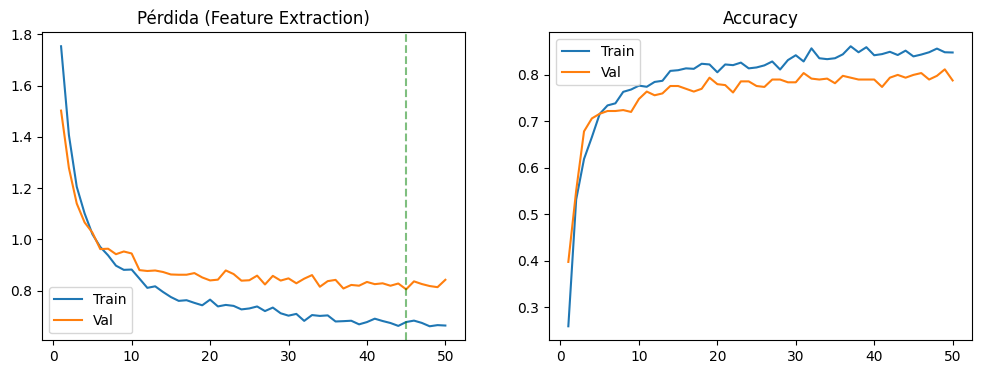


=== Exp 2: Evaluación Final ===
Evaluando modelo en xpu...

MÉTRICAS GLOBALES
Accuracy Global: 0.7992
F1-Score Macro:  0.7714

REPORTE POR CLASE
              precision    recall  f1-score   support

   cardboard       0.97      0.84      0.90        80
       glass       0.78      0.86      0.82       100
       metal       0.77      0.82      0.79        82
       paper       0.88      0.79      0.83       118
     plastic       0.85      0.73      0.79        96
       trash       0.39      0.70      0.50        27

    accuracy                           0.80       503
   macro avg       0.77      0.79      0.77       503
weighted avg       0.82      0.80      0.81       503



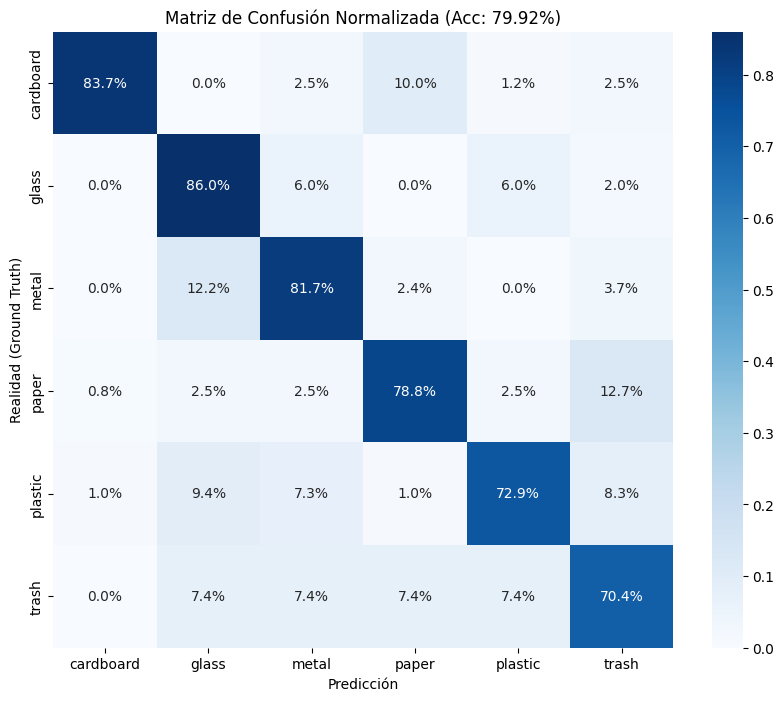

In [39]:
# BASELINE 2: TRANSFER LEARNING (FEATURE EXTRACTION)


"""
JUSTIFICACIÓN TÉCNICA:
Utilizamos una ResNet18 pre-entrenada en ImageNet.
- Estrategia: Feature Extraction (congelamos todas las capas convolucionales).
- Motivo: Aprovechar los filtros de detección de texturas y formas ya aprendidos
  por la red en millones de imágenes, entrenando solo la capa de clasificación final
  para adaptarla a nuestras 6 clases de basura. Esto reduce drásticamente el riesgo
  de overfitting dado el tamaño pequeño de nuestro dataset.
"""

from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
import time
import copy
import matplotlib.pyplot as plt

# --- 1. FUNCIÓN DE CREACIÓN DE MODELO (Aporte del equipo) ---
def create_resnet18_model(num_classes: int,
                          feature_extractor: bool = True,
                          unfreeze_last_block: bool = False) -> nn.Module:
    """
    Crea un modelo ResNet18 adaptado.
    - feature_extractor=True: Congela el backbone.
    - unfreeze_last_block=True: Descongela también el layer4 (para Fine Tuning).
    
    Mantiene compatibilidad con versiones viejas y nuevas de torchvision.
    """
    # Lógica robusta para cargar pesos según la versión de torchvision instalada
    try:
        # Para versiones nuevas de torchvision
        weights = models.ResNet18_Weights.DEFAULT
        backbone = models.resnet18(weights=weights)
    except AttributeError:
        # Fallback para versiones antiguas
        backbone = models.resnet18(pretrained=True)

    # Reemplazar la capa final (FC)
    in_feats = backbone.fc.in_features
    backbone.fc = nn.Linear(in_feats, num_classes)

    # Congelar pesos del backbone si es feature extractor
    if feature_extractor:
        for param in backbone.parameters():
            param.requires_grad = False

    # Siempre entrenamos la nueva capa final (FC)
    for param in backbone.fc.parameters():
        param.requires_grad = True

    # Lógica opcional: Fine-tuning parcial (desbloquear layer4)
    # Útil si feature_extractor es False pero queremos congelar las primeras capas
    if unfreeze_last_block:
        for param in backbone.layer4.parameters():
            param.requires_grad = True

    return backbone.to(DEVICE)

# --- 2. CONFIGURACIÓN DEL EXPERIMENTO ---

# Instanciamos para Feature Extraction (congelado total excepto FC)
model_fe = create_resnet18_model(
    num_classes=num_classes, 
    feature_extractor=True, 
    unfreeze_last_block=False
)

# Configuración de entrenamiento
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.05)
# Optimizamos solo los parámetros que requieren gradiente (la capa FC)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_fe.parameters()), 
                        lr=1e-3, weight_decay=1e-4)

# Hiperparámetros (Iguales al baseline para comparar)
MAX_EPOCHS = 50
PATIENCE = 8

# --- 3. BUCLE DE ENTRENAMIENTO ---
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None
train_losses, val_losses, train_accs, val_accs = [], [], [], []

print(f"\n=== Exp 2: Iniciando Feature Extraction en {DEVICE} ===")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS + 1):
    # Train
    model_fe.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model_fe(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Val
    model_fe.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            outputs = model_fe(images)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # Logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model_fe.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️ Early stopping activado.")
            break

if best_model_state:
    model_fe.load_state_dict(best_model_state)
    print("✅ Mejor modelo restaurado.")

# Visualización
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Val")
plt.axvline(x=len(train_losses)-patience_counter, color='g', linestyle='--', alpha=0.5)
plt.title("Pérdida (Feature Extraction)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train")
plt.plot(epochs_range, val_accs, label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

# Evaluación Final
print("\n=== Exp 2: Evaluación Final ===")
metrics_resnet_fe = evaluate_classification_model(model_fe, val_loader, class_names, DEVICE)

In [40]:
print("\n=== Resumen comparativo (Val acc / F1-macro) ===")
print(f"SimpleCNN      -> acc: {metrics_simplecnn['accuracy']:.4f}, F1-macro: {metrics_simplecnn['f1_macro']:.4f}")
print(f"ResNet18 FE    -> acc: {metrics_resnet_fe['accuracy']:.4f}, F1-macro: {metrics_resnet_fe['f1_macro']:.4f}")




=== Resumen comparativo (Val acc / F1-macro) ===
SimpleCNN      -> acc: 0.6044, F1-macro: 0.5874
ResNet18 FE    -> acc: 0.7992, F1-macro: 0.7714


### Resultados del Baseline 2 — ResNet18 (Feature Extractor)

La aplicación de **Transfer Learning** mediante una **ResNet18** pre-entrenada marca un salto cualitativo indiscutible en el desempeño del modelo, validando empíricamente la hipótesis de que las características visuales universales (bordes, texturas, formas) aprendidas en **ImageNet** son altamente transferibles al dominio de residuos.

### Métricas Globales y Estabilidad

* **Accuracy Global:** **79.92%** (Un incremento masivo de ~20 puntos respecto al 60.44% del Baseline 1).
* **F1-Macro:** **0.7714** (Superior al 0.5874 del modelo anterior).
* **Convergencia:** El modelo alcanzó una meseta de alto rendimiento rápidamente (superando el 77% en la época 14) y se mantuvo estable, logrando su mejor punto de validación en la época 45 (Loss 0.80), lo que demuestra la robustez de los pesos pre-entrenados.

### Desempeño por Clase

La red resolvió gran parte de la confusión entre materiales similares que limitaba a la CNN simple:

* **Cardboard (Cartón):** Alcanzó un rendimiento excelente con **F1 de 0.90** y precisión del 97%.
* **Glass (Vidrio):** El salto más impresionante. Pasó de ser una clase crítica (F1 0.54) a una sólida (**F1 0.82**), demostrando que los filtros pre-entrenados captan eficazmente las texturas translúcidas y reflejos.
* **Metal:** Subió drásticamente a un **F1 de 0.79** (antes 0.48). La capacidad de detectar bordes afilados y brillos metálicos mejoró notablemente.
* **Plastic:** Consolidó su separación con un **F1 de 0.79**, reduciendo la confusión con el vidrio.
* **Trash (Basura Genérica):** Aunque mejoró (F1 0.50), sigue siendo la clase más débil (*Recall* 0.70 pero *Precision* baja de 0.39). Esto indica que el modelo aún tiende a usar esta categoría como "cajón de sastre" para objetos ambiguos.

### Conclusión

El uso de **Feature Extraction** ha demostrado ser una estrategia muy superior a entrenar desde cero. Sin embargo, el estancamiento en un ~80% de accuracy y los errores residuales en la clase *Trash* sugieren que las características genéricas de ImageNet no son suficientes para captar todas las sutilezas de la basura.

El modelo basado en **ResNet18** se establece como un nuevo y robusto *baseline*, pero para superar esta barrera de rendimiento, será necesario aplicar **Fine-Tuning**, permitiendo que las capas profundas de la red se especialicen en las texturas específicas de este dataset.

# Selección de Arquitecturas y Uso de Transfer Learning


### Estrategia de Experimentación: Selección de Arquitecturas y Transfer Learning

Para la fase final de este trabajo, hemos diseñado un experimento comparativo exhaustivo evaluando **cinco arquitecturas** de aprendizaje profundo. El objetivo es analizar cómo diferentes paradigmas de diseño —desde las convoluciones clásicas y profundas hasta los mecanismos de atención modernos— se comportan frente al desafío de clasificar residuos con un dataset limitado.

#### 1. Modelos Seleccionados

Hemos seleccionado un conjunto de modelos que representan hitos teóricos distintos, permitiéndonos evaluar diferentes compromisos entre precisión, eficiencia y complejidad:

1.  **ResNet-18 (El Estándar Robusto):**  Actúa como nuestro modelo de control. Su uso de conexiones residuales (*skip connections*) permite entrenar redes profundas evitando la degradación del gradiente. En esta fase, evolucionaremos del *feature extraction* al *fine-tuning* para desbloquear su máximo potencial.
2.  **MobileNetV2 (La Eficiente):**  Representante de la eficiencia. Su arquitectura basada en *convoluciones separables en profundidad* y *residuos invertidos* busca maximizar el rendimiento con el menor costo computacional posible, simulando un escenario realista de despliegue en dispositivos móviles o sistemas embebidos de reciclaje.
3.  **DenseNet-121 (Memoria Profunda):**  Representante de la reutilización de características. Cada capa recibe como entrada los mapas de todas las capas anteriores. Esta densidad de conexiones fomenta una fuerte propagación de características, lo cual es teóricamente ideal para exprimir al máximo la información en datasets pequeños (*Small Data*).
4.  **InceptionV3 (Procesamiento Multi-Escala):**  Seleccionada por su capacidad de procesar la imagen con filtros de distintos tamaños ($1\times1, 3\times3, 5\times5$) en paralelo. Esto es crucial para residuos, donde los objetos pueden variar enormemente en tamaño y relación de aspecto.
    * *Nota Técnica:* Esta arquitectura requiere una resolución de entrada mayor (**299x299**), por lo que ajustamos nuestro *pipeline* de datos específicamente para este modelo, a diferencia del estándar de 224x224 usado en los otros.
5.  **Vision Transformer - ViT (El Cambio de Paradigma):** 

[Image of Vision Transformer architecture diagram]
 Incorporamos el estado del arte moderno. A diferencia de las CNNs, ViT utiliza mecanismos de **Auto-Atención** (*Self-Attention*) para modelar relaciones globales en la imagen. Nuestro objetivo es evaluar si este paradigma, que usualmente requiere millones de datos, puede adaptarse a *TrashNet* mediante un Transfer Learning agresivo.

#### 2. El Rol Crítico del Transfer Learning

La decisión de aplicar **Transfer Learning** (inicializando todas las redes con pesos de **ImageNet**) no es solo una elección técnica, sino la **piedra angular** de nuestra estrategia para superar las limitaciones del dataset.

Nuestros experimentos preliminares confirmaron la hipótesis de que el aprendizaje desde cero es inviable para alcanzar métricas de alto nivel con solo ~2,500 imágenes:
* **SimpleCNN (Desde Cero):** Se estancó en un **55% de Accuracy**, fallando críticamente en distinguir materiales complejos como el vidrio (F1: 0.33) o el metal (F1: 0.49).
* **ResNet-18 (Transfer Learning):** Al utilizar pesos pre-entrenados, el rendimiento se disparó a un **80% de Accuracy** (+25 puntos). Lo más revelador fue el impacto en las clases difíciles: el F1 de **Vidrio** saltó de 0.33 a **0.81**.

Este contraste demuestra que las primeras capas de las redes pre-entrenadas ya poseen filtros optimizados para detectar características visuales universales (transparencias, reflejos especulares, texturas finas) que nuestro dataset pequeño no basta para enseñar desde cero.

Por lo tanto, para los 5 modelos seleccionados aplicaremos una estrategia de **Fine-Tuning**: partiremos del conocimiento previo de ImageNet y descongelaremos selectivamente las últimas capas. Esto permitirá que las redes adapten sus representaciones semánticas de alto nivel a las particularidades de los residuos (ej. deformaciones, suciedad), buscando romper la barrera de rendimiento establecida por el Baseline 2.


Para garantizar una evaluación **justa y rigurosa**, no aplicamos un barrido de hiperparámetros genérico ("Grid Search ciego"). En su lugar, diseñamos un esquema de experimentación dirigido, donde las variaciones de hiperparámetros responden a las **características estructurales y necesidades teóricas** de cada arquitectura.

Ejecutamos un total de **20 experimentos controlados** (4 configuraciones por modelo), variando las siguientes dimensiones clave:

---

### 1. ResNet-18 (El Estándar Robusto)
* **Foco:** Profundidad del **Fine-Tuning**.
* **Estrategia:** Dada la estabilidad de las conexiones residuales, probamos descongelar solo el último bloque convolucional frente a descongelar los dos últimos bloques.
* **Optimizador:** Contrastamos la convergencia moderna de **AdamW** ($5e-4, 1e-4$) contra la generalización clásica de **SGD con Momentum** ($4e-3, 1e-3$), buscando si un mínimo más plano mejora el rendimiento en test.

---

### 2. MobileNetV2 (La Eficiente y Ligera)
* **Foco:** Regularización contra el **Overfitting**.
* **Estrategia:** Al ser una red con pocos parámetros, es propensa a memorizar el *dataset* pequeño. Variamos la tasa de **Dropout** entre un valor estándar (**0.2**) y uno agresivo (**0.5**) para forzar la robustez.
* **Optimizador:** Comparamos **AdamW** contra **RMSprop**, siendo este último el optimizador nativo recomendado en el paper original de MobileNet.

---

### 3. DenseNet-121 (Profundidad y Memoria)
* **Foco:** Tasa de Aprendizaje (**Learning Rate**).
* **Estrategia:** Las redes densas propagan gradientes fuertes. Probamos un rango amplio de tasas de aprendizaje, desde valores conservadores con **AdamW** ($1e-4, 5e-5$) hasta valores más altos con **SGD** ($1e-3, 5e-4$), dado que DenseNet suele beneficiarse de un entrenamiento estocástico más vigoroso.

---

### 4. InceptionV3 (Procesamiento Multi-Escala)
* **Foco:** Resolución y Estabilidad.
* **Ajuste Crítico:** Respetamos su **resolución de entrada nativa de 299x299**, utilizando un *pipeline* de datos diferenciado para no degradar su capacidad de capturar detalles finos.
* **Estrategia:** Evaluamos la estabilidad del entrenamiento comparando **RMSprop** (diseño original de Google) frente a **AdamW**, ajustando el *Learning Rate* ($1e-4$ vs $5e-4$) para compensar el mayor tamaño de entrada.

---

### 5. Vision Transformer - ViT (El Desafío sin Sesgo Inductivo)
* **Foco:** Estabilidad en *Small Data*.
* **Estrategia:** Los **Transformers** carecen del sesgo inductivo de las CNNs y son inestables con pocos datos. Aplicamos tasas de aprendizaje "microscópicas" ($5e-5, 1e-5$) y variamos el **Weight Decay** ($1e-2$ vs $1e-4$) para controlar estrictamente la magnitud de los pesos y evitar el colapso del entrenamiento.

Se deja todo en una sola celda autopcontinda para facilitar entrenameinto

Total experimentos: 21
Ejecutando 21 experimentos...

Iniciando: ResNet_adamw_last_block_lr0.0005................................... F1: 0.9116

Iniciando: ResNet_adamw_last_block_lr1e-4.............................. F1: 0.9056

Iniciando: ResNet_adamw_last_2_blocks_lr0.0005.................................. F1: 0.9403

Iniciando: ResNet_sgd_last_block_lr0.004........................................... F1: 0.8646

Iniciando: ResNet_sgd_last_2_blocks_lr0.004.................................. F1: 0.8980

Iniciando: Mobile_adamw_d0.2.......................................... F1: 0.9008

Iniciando: Mobile_adamw_d0.5................................ F1: 0.8935

Iniciando: Mobile_rmsprop_d0.2............................. F1: 0.9009

Iniciando: Mobile_rmsprop_d0.5........................................ F1: 0.9025

Iniciando: Dense_SGD_lr0.001......................................... F1: 0.8314

Iniciando: Dense_SGD_lr0.0005......................................... F1: 0.8027

Iniciando: Dense

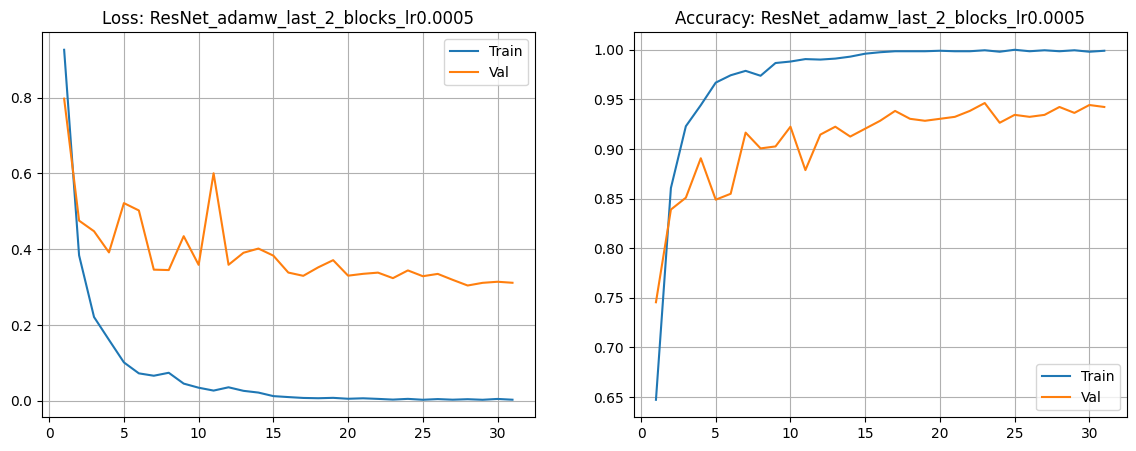

Evaluando Matriz de Confusión del Campeón...
Evaluando modelo en xpu...

MÉTRICAS GLOBALES
Accuracy Global: 0.9463
F1-Score Macro:  0.9403

REPORTE POR CLASE
              precision    recall  f1-score   support

   cardboard       0.97      0.97      0.97        80
       glass       0.93      0.96      0.95       100
       metal       0.91      0.96      0.93        82
       paper       0.99      0.92      0.96       118
     plastic       0.95      0.93      0.94        96
       trash       0.86      0.93      0.89        27

    accuracy                           0.95       503
   macro avg       0.94      0.95      0.94       503
weighted avg       0.95      0.95      0.95       503



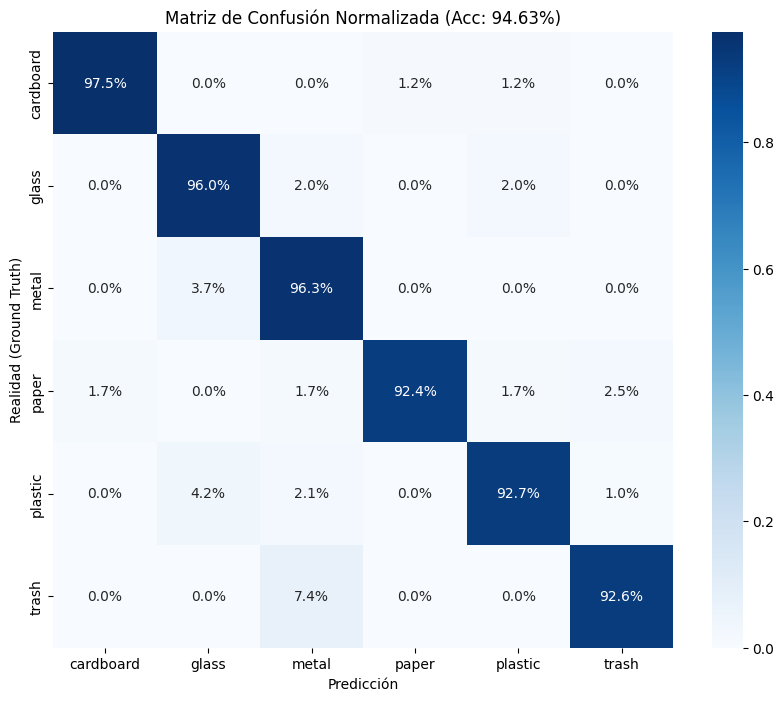

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import pandas as pd
import time
import copy
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import random

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

output_dir = "modelos_seleccionados"
os.makedirs(output_dir, exist_ok=True)

# 1. DataLoaders
def create_dataloaders(img_size, batch_size, workers):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    val_tfms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    train_ds_full = datasets.ImageFolder(dataset_dir, transform=train_tfms)
    val_ds_full = datasets.ImageFolder(dataset_dir, transform=val_tfms)

    train_ds = Subset(train_ds_full, train_indices)
    val_ds = Subset(val_ds_full, val_indices)

    t_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                          num_workers=workers, pin_memory=(DEVICE.type != 'cpu'), persistent_workers=(workers > 0))
    v_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, 
                          num_workers=workers, pin_memory=(DEVICE.type != 'cpu'), persistent_workers=(workers > 0))
    
    return t_loader, v_loader

loaders_224 = create_dataloaders(img_size=224, batch_size=BATCH_SIZE, workers=WORKERS)
loaders_299 = create_dataloaders(img_size=299, batch_size=max(32, int(BATCH_SIZE*0.75)), workers=WORKERS)

# 2. Modelos
def get_advanced_model(arch_name, num_classes, dropout_rate=0.0, unfreeze_depth='last_block'):
    if arch_name == 'resnet18':
        model = models.resnet18(weights='DEFAULT')
        model.fc = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(model.fc.in_features, num_classes))
        blocks = {'last_block': ['layer4', 'fc'], 'last_2_blocks': ['layer3', 'layer4', 'fc']}

    elif arch_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights='DEFAULT')
        model.classifier = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(model.classifier[1].in_features, num_classes))
        blocks = {'last_block': ['features.18', 'classifier'], 'last_2_blocks': ['features.14', 'features.18', 'classifier']}

    elif arch_name == 'densenet121':
        model = models.densenet121(weights='DEFAULT')
        model.classifier = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(model.classifier.in_features, num_classes))
        blocks = {'last_block': ['denseblock4', 'norm5', 'classifier'], 'last_2_blocks': ['denseblock3', 'denseblock4', 'norm5', 'classifier']}

    elif arch_name == 'inception_v3':
        model = models.inception_v3(weights='DEFAULT')
        model.aux_logits = False 
        model.fc = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(model.fc.in_features, num_classes))
        blocks = {'last_block': ['Mixed_7c', 'fc'], 'last_2_blocks': ['Mixed_7b', 'Mixed_7c', 'fc']}

    elif arch_name == 'vit_b_16':
        model = models.vit_b_16(weights='DEFAULT')
        model.heads = nn.Sequential(nn.Dropout(p=dropout_rate), nn.Linear(model.heads.head.in_features, num_classes))
        blocks = {'last_block': ['encoder_layer_11', 'heads'], 'last_2_blocks': ['encoder_layer_10', 'encoder_layer_11', 'heads']}
    else:
        raise ValueError(f"Arquitectura {arch_name} no soportada")

    for param in model.parameters():
        param.requires_grad = False
    
    layers_to_unfreeze = blocks.get(unfreeze_depth, [])
    for name, param in model.named_parameters():
        for layer_keyword in layers_to_unfreeze:
            if layer_keyword in name:
                param.requires_grad = True
                break
    return model.to(DEVICE)

# 3. Grid de Hiperparámetros
grid_configs = []

# ResNet18
for opt in ['adamw', 'sgd']:
    for depth in ['last_block', 'last_2_blocks']:
        lr_high = 5e-4 if opt=='adamw' else 4e-3
        grid_configs.append({"arch": "resnet18", "opt": opt, "lr": lr_high, "wd": 1e-3, "drop": 0.5, "depth": depth, "desc": f"ResNet_{opt}_{depth}_lr{lr_high}"})
        if opt == 'adamw' and depth == 'last_block':
             grid_configs.append({"arch": "resnet18", "opt": opt, "lr": 1e-4, "wd": 1e-3, "drop": 0.5, "depth": depth, "desc": f"ResNet_{opt}_{depth}_lr1e-4"})

# MobileNetV2
for opt in ['adamw', 'rmsprop']:
    for drop in [0.2, 0.5]:
        grid_configs.append({"arch": "mobilenet_v2", "opt": opt, "lr": 1e-3, "wd": 1e-4, "drop": drop, "depth": "last_block", "desc": f"Mobile_{opt}_d{drop}"})

# DenseNet121
for lr in [1e-3, 5e-4]:
    grid_configs.append({"arch": "densenet121", "opt": "sgd", "lr": lr, "wd": 1e-4, "drop": 0.2, "depth": "last_block", "desc": f"Dense_SGD_lr{lr}"})
for lr in [1e-4, 5e-5]:
    grid_configs.append({"arch": "densenet121", "opt": "adamw", "lr": lr, "wd": 1e-3, "drop": 0.2, "depth": "last_block", "desc": f"Dense_AdamW_lr{lr}"})

# InceptionV3
for opt in ['rmsprop', 'adamw']:
    for lr in [1e-4, 5e-4]:
        grid_configs.append({"arch": "inception_v3", "opt": opt, "lr": lr, "wd": 1e-4, "drop": 0.4, "depth": "last_block", "desc": f"Incep_{opt}_lr{lr}"})

# Vision Transformer
for lr in [5e-5, 1e-5]:
    for wd in [1e-2, 1e-4]:
        grid_configs.append({"arch": "vit_b_16", "opt": "adamw", "lr": lr, "wd": wd, "drop": 0.0, "depth": "last_block", "desc": f"ViT_lr{lr}_wd{wd}"})

print(f"Total experimentos: {len(grid_configs)}")

# 4. Bucle de Entrenamiento
def run_experiment(config, max_epochs=40, patience=8):
    print(f"\nIniciando: {config['desc']}...", end="")
    
    if config['arch'] == 'inception_v3':
        loader_train, loader_val = loaders_299
    else:
        loader_train, loader_val = loaders_224
    
    model = get_advanced_model(config['arch'], num_classes, 
                               dropout_rate=config.get('drop', 0.0), 
                               unfreeze_depth=config['depth'])
    
    params = filter(lambda p: p.requires_grad, model.parameters())
    
    if config['opt'] == 'adamw':
        optimizer = optim.AdamW(params, lr=config['lr'], weight_decay=config['wd'])
    elif config['opt'] == 'sgd':
        optimizer = optim.SGD(params, lr=config['lr'], momentum=0.9, weight_decay=config['wd'])
    elif config['opt'] == 'rmsprop':
        optimizer = optim.RMSprop(params, lr=config['lr'], alpha=0.9, weight_decay=config['wd'])
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.0)
    
    best_f1 = 0.0
    best_weights = None
    patience_ctr = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(max_epochs):
        model.train()
        r_loss, r_corr, total_train = 0.0, 0, 0
        for imgs, tgts in loader_train:
            imgs, tgts = imgs.to(DEVICE), tgts.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            if isinstance(out, tuple): out = out.logits
            
            loss = criterion(out, tgts)
            loss.backward()
            optimizer.step()
            r_loss += loss.item() * imgs.size(0)
            r_corr += (out.argmax(1) == tgts).sum().item()
            total_train += imgs.size(0)
        
        scheduler.step()
        
        model.eval()
        v_loss, v_corr, total_val = 0.0, 0, 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for imgs, tgts in loader_val:
                imgs, tgts = imgs.to(DEVICE), tgts.to(DEVICE)
                out = model(imgs)
                loss = criterion(out, tgts)
                v_loss += loss.item() * imgs.size(0)
                v_corr += (out.argmax(1) == tgts).sum().item()
                total_val += imgs.size(0)
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_targets.extend(tgts.cpu().numpy())
        
        val_f1 = f1_score(all_targets, all_preds, average='macro')
        
        history['train_loss'].append(r_loss / total_train)
        history['train_acc'].append(r_corr / total_train)
        history['val_loss'].append(v_loss / total_val)
        history['val_acc'].append(v_corr / total_val)
        
        print(".", end="")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_weights = copy.deepcopy(model.state_dict())
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                break
    
    print(f" F1: {best_f1:.4f}")
    
   
    return {"Config": config, "Best F1": best_f1, "Weights": best_weights, "History": history}

# 5. Ejecución y Selección Inteligente
results = []
start_global = time.time()

print(f"Ejecutando {len(grid_configs)} experimentos...")

for i, conf in enumerate(grid_configs):
    res = run_experiment(conf)
     
    
    
    
    results.append(res)

print(f"\nEntrenamiento finalizado en {(time.time()-start_global)/3600:.2f} horas")

# 6. Selección y Guardado
df = pd.DataFrame([{**r['Config'], 'Best F1': r['Best F1'], 'Idx': i} for i, r in enumerate(results)])

# Identificar Top 5 Globales
top_5_indices = df.nlargest(5, 'Best F1')['Idx'].tolist()

# Identificar Mejor de cada Arquitectura
best_per_arch_indices = df.loc[df.groupby("arch")["Best F1"].idxmax()]['Idx'].tolist()

# Unión de índices (sin duplicados)
indices_to_save = list(set(top_5_indices + best_per_arch_indices))

print(f"\nGuardando {len(indices_to_save)} modelos seleccionados (Top 5 + Mejores por Arq)...")

for idx in indices_to_save:
    res = results[idx]
    safe_name = res['Config']['desc'].replace(" ", "_").replace(".", "p")
    filename = f"{output_dir}/{safe_name}_F1_{res['Best F1']:.4f}.pth"
    
    if res["Weights"]:
        torch.save(res["Weights"], filename)
        print(f" Guardado: {filename}")
        
    # Si es el campeón absoluto, guardarlo como 'ganador'
    if idx == df['Best F1'].idxmax():
        torch.save(res["Weights"], "modelo_ganador_absoluto.pth")
        best_res_data = res 
        print(" GUARDADO COMO CAMPEÓN ABSOLUTO")

# Reportes
print("\n=== RANKING TOP 10 ===")
print(df[['desc', 'arch', 'Best F1']].sort_values(by='Best F1', ascending=False).head(10).to_string(index=False))

# Gráficas del Ganador
if best_res_data:
    h = best_res_data['History']
    ep = range(1, len(h['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ep, h['train_loss'], label='Train')
    plt.plot(ep, h['val_loss'], label='Val')
    plt.title(f"Loss: {best_res_data['Config']['desc']}")
    plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(ep, h['train_acc'], label='Train')
    plt.plot(ep, h['val_acc'], label='Val')
    plt.title(f"Accuracy: {best_res_data['Config']['desc']}")
    plt.legend(); plt.grid(True)
    plt.show()

    print("Evaluando Matriz de Confusión del Campeón...")
    final_model = get_advanced_model(best_res_data['Config']['arch'], num_classes, 
                                     dropout_rate=best_res_data['Config'].get('drop',0), 
                                     unfreeze_depth=best_res_data['Config']['depth'])
    final_model.load_state_dict(torch.load("modelo_ganador_absoluto.pth"))
    final_model.to(DEVICE)
    
    eval_loader = loaders_299[1] if best_res_data['Config']['arch'] == 'inception_v3' else loaders_224[1]
    evaluate_classification_model(final_model, eval_loader, class_names, DEVICE)

Graficando curvas para los 5 mejores modelos...


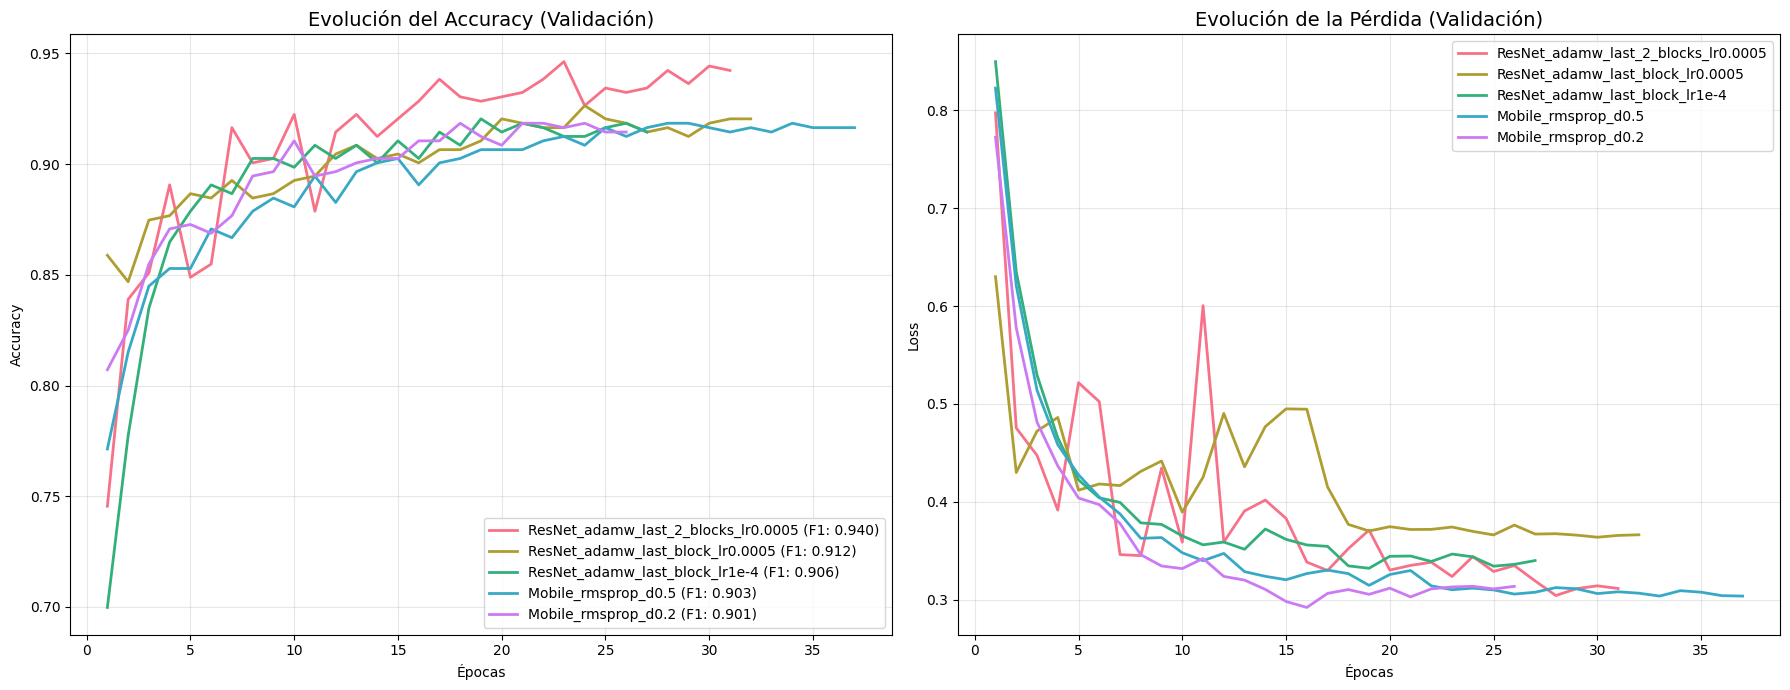

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar los Top 5 Modelos
top_results = sorted(results, key=lambda x: x['Best F1'], reverse=True)[:5]

print(f"Graficando curvas para los {len(top_results)} mejores modelos...")

# Configurar el gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Colores para distinguir modelos
colors = sns.color_palette("husl", len(top_results))

for i, res in enumerate(top_results):
    name = res['Config']['desc']
    hist = res['History']
    epochs = range(1, len(hist['val_acc']) + 1)
    
    # --- Gráfico de Accuracy (Validación) ---
    
    ax1.plot(epochs, hist['val_acc'], label=f"{name} (F1: {res['Best F1']:.3f})", 
             color=colors[i], linewidth=2)


    # --- Gráfico de Loss (Validación) ---
    ax2.plot(epochs, hist['val_loss'], label=f"{name}", 
             color=colors[i], linewidth=2)

# Decoración
ax1.set_title("Evolución del Accuracy (Validación)", fontsize=14)
ax1.set_xlabel("Épocas")
ax1.set_ylabel("Accuracy")
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

ax2.set_title("Evolución de la Pérdida (Validación)", fontsize=14)
ax2.set_xlabel("Épocas")
ax2.set_ylabel("Loss")
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()